### Downloads and Imports

In [0]:
# Downloads
! pip install -q -U google-generativeai
! pip install wikipedia
!python -m nltk.downloader stopwords
!pip install squarify
!pip install spacy
!python -m spacy download en_core_web_md

# Pyspark imports
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, explode, split, desc, count
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

# Data enrichment libraries imports - Wikipedia module and Gemini LLM
import wikipedia
import google.generativeai as genai
genai.configure(api_key=YOUR_API_KEY)
model = genai.GenerativeModel('gemini-pro')

# other imports - Basic tools, NLP tools, ML tools
import re
import pathlib
import textwrap
import random
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, Markdown
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
import squarify
import spacy
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1195d8ab-7003-4807-841b-d55a7368e02b/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 147 kB 52.3 MB/s 
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=e00cc5e713da7cd2da961232246d339778844215cab259fd7b0ada797d8b608a
  Stored in directory: /root/.cache/pip/wheels/c2/46/f4/caa1bee71096d7b0cdca2f2a2af45cacf35c5760bee8f00948
Successfully built wikipedia
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1195d8ab-7003-4807-841b-d55a7368e02b/bin/python -m pip install --upgrade pip' command.
/usr/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data] 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Start Spark Session and Load LinkedIn Data

In [0]:
spark = SparkSession.builder.getOrCreate()
profiles = spark.read.parquet('/linkedin/people')
companies = spark.read.parquet('/linkedin/companies')

### LinkedIn Data Proccessing

In [0]:
meta_industries_12 = {
    'Furniture and Home Furnishings Manufacturing': 'Manufacturing',
    'Investment Banking': 'Financial and Investment',
    'Architecture and Planning': 'Services',
    'Wholesale': 'Services',
    'Travel Arrangements': 'Services',
    'Ranching': 'Miscellaneous',
    'Hospitals and Health Care': 'Healthcare and Medical',
    'Book and Periodical Publishing': 'Services',
    'Printing Services': 'Services',
    'Professional Training and Coaching': 'Services',
    'Computers and Electronics Manufacturing': 'Manufacturing',
    'Shipbuilding': 'Manufacturing',
    'Public Policy Offices': 'Government and Public Policy',
    'Software Development': 'Technology',
    'Outsourcing and Offshoring Consulting': 'Services',
    'Retail Groceries': 'Retail and Consumer Goods',
    'Education Administration Programs': 'Education and Training',
    'Plastics Manufacturing': 'Manufacturing',
    'Renewable Energy Semiconductor Manufacturing': 'Manufacturing',
    'Computer Networking Products': 'Technology',
    'Events Services': 'Services',
    'Information Services': 'Services',
    'Food and Beverage Services': 'Services',
    'Semiconductor Manufacturing': 'Manufacturing',
    'Business Consulting and Services': 'Services',
    'Insurance': 'Services',
    'Financial Services': 'Services',
    'Wireless Services': 'Services',
    'Computer Hardware Manufacturing': 'Technology',
    'Public Safety': 'Services',
    'Maritime Transportation': 'Transportation and Logistics',
    'Tobacco Manufacturing': 'Manufacturing',
    'Writing and Editing': 'Services',
    'Veterinary Services': 'Services',
    'Staffing and Recruiting': 'Services',
    'Accounting': 'Services',
    'International Affairs': 'Government and Public Policy',
    'Spectator Sports': 'Miscellaneous',
    'Glass, Ceramics and Concrete Manufacturing': 'Manufacturing',
    'Chemical Manufacturing': 'Manufacturing',
    'Mining': 'Miscellaneous',
    'E-Learning Providers': 'Technology',
    'Security and Investigations': 'Services',
    'Translation and Localization': 'Services',
    'Automation Machinery Manufacturing': 'Technology',
    'Computer and Network Security': 'Technology',
    'Political Organizations': 'Government and Public Policy',
    'Environmental Services': 'Government and Public Policy',
    'Oil and Gas': 'Miscellaneous',
    'Real Estate': 'Real Estate and Construction',
    'Think Tanks': 'Government and Public Policy',
    'Executive Offices': 'Miscellaneous',
    'Law Practice': 'Services',
    'Nanotechnology Research': 'Miscellaneous',
    'International Trade and Development': 'Government and Public Policy',
    'Personal Care Product Manufacturing': 'Manufacturing',
    'Philanthropic Fundraising Services': 'Services',
    'Entertainment Providers': 'Media and Entertainment',
    'Market Research': 'Media and Entertainment',
    'Movies, Videos, and Sound': 'Media and Entertainment',
    'Sporting Goods Manufacturing': 'Manufacturing',
    'Graphic Design': 'Services',
    'Technology, Information and Internet': 'Technology',
    'IT Services and IT Consulting': 'Technology',
    'Retail Office Equipment': 'Retail and Consumer Goods',
    'Wholesale Import and Export': 'Services',
    'Capital Markets': 'Financial and Investment',
    'Law Enforcement': 'Services',
    'Freight and Package Transportation': 'Transportation and Logistics',
    'Industrial Machinery Manufacturing': 'Manufacturing',
    'Non-profit Organizations': 'Miscellaneous',
    'Retail Art Supplies': 'Retail and Consumer Goods',
    'Animation and Post-production': 'Media and Entertainment',
    'Transportation, Logistics, Supply Chain and Storage': 'Transportation and Logistics',
    'Aviation and Aerospace Component Manufacturing': 'Transportation and Logistics',
    'Fundraising': 'Financial and Investment',
    'Railroad Equipment Manufacturing': 'Transportation and Logistics',
    'Construction': 'Real Estate and Construction',
    'Investment Management': 'Financial and Investment',
    'Utilities': 'Miscellaneous',
    'Retail Luxury Goods and Jewelry': 'Retail and Consumer Goods',
    'Warehousing and Storage': 'Transportation and Logistics',
    'Media Production': 'Media and Entertainment',
    'Gambling Facilities and Casinos': 'Media and Entertainment',
    'Defense and Space Manufacturing': 'Manufacturing',
    'Facilities Services': 'Services',
    'Government Relations Services': 'Government and Public Policy',
    'Advertising Services': 'Media and Entertainment',
    'Paper and Forest Product Manufacturing': 'Manufacturing',
    'Packaging and Containers Manufacturing': 'Manufacturing',
    'Telecommunications': 'Technology',
    'Medical Equipment Manufacturing': 'Healthcare and Medical',
    'Beverage Manufacturing': 'Manufacturing',
    'Restaurants': 'Retail and Consumer Goods',
    'Leasing Non-residential Real Estate': 'Real Estate and Construction',
    'Newspaper Publishing': 'Media and Entertainment',
    'Armed Forces': 'Miscellaneous',
    'Appliances, Electrical, and Electronics Manufacturing': 'Manufacturing',
    'Hospitality': 'Services',
    'Pharmaceutical Manufacturing': 'Healthcare and Medical',
    'Research Services': 'Services',
    'Retail Apparel and Fashion': 'Retail and Consumer Goods',
    'Photography': 'Media and Entertainment',
    'Wellness and Fitness Services': 'Services',
    'Truck Transportation': 'Transportation and Logistics',
    'Consumer Services': 'Services',
    'Wholesale Building Materials': 'Services',
    'Human Resources Services': 'Services',
    'Airlines and Aviation': 'Transportation and Logistics',
    'Machinery Manufacturing': 'Manufacturing',
    'Individual and Family Services': 'Services',
    'Motor Vehicle Manufacturing': 'Manufacturing',
    'Performing Arts': 'Media and Entertainment',
    'Museums, Historical Sites, and Zoos': 'Media and Entertainment',
    'Broadcast Media Production and Distribution': 'Media and Entertainment',
    'Banking': 'Financial and Investment',
    'Recreational Facilities': 'Miscellaneous',
    'Government Administration': 'Government and Public Policy',
    'Public Relations and Communications Services': 'Media and Entertainment',
    'Fisheries': 'Miscellaneous',
    'Medical Practices': 'Healthcare and Medical',
    'Religious Institutions': 'Miscellaneous',
    'Online Audio and Video Media': 'Media and Entertainment',
    'Artists and Writers': 'Miscellaneous',
    'Biotechnology Research': 'Healthcare and Medical',
    'Legal Services': 'Services',
    'Retail': 'Retail and Consumer Goods',
    'Civil Engineering': 'Services',
    'Libraries': 'Miscellaneous',
    'Alternative Dispute Resolution': 'Miscellaneous',
    'Manufacturing': 'Miscellaneous',
    'Design Services': 'Services',
    'Dairy Product Manufacturing': 'Manufacturing',
    'Higher Education': 'Education and Training',
    'Civic and Social Organizations': 'Miscellaneous',
    'Textile Manufacturing': 'Manufacturing',
    'Venture Capital and Private Equity Principals': 'Financial and Investment',
    'Mental Health Care': 'Healthcare and Medical',
    'Musicians': 'Media and Entertainment',
    'Farming': 'Miscellaneous',
    'Computer Games': 'Media and Entertainment',
    'Strategic Management Services': 'Services',
    'Food and Beverage Manufacturing': 'Manufacturing',
    'Primary and Secondary Education': 'Education and Training',
    'Alternative Medicine': 'Healthcare and Medical',
    'Legislative Offices': 'Services',
    'Administration of Justice': 'Services',
    'Mobile Gaming Apps': 'Media and Entertainment'
}

meta_industry = udf(lambda x: meta_industries_12[x] )
companies = companies.filter(companies.industries.isNotNull())
companies = companies.withColumn('meta_industry', meta_industry(col('industries')))


In [0]:
# Select specific columns and explode 'posts' column, retaining null values
small_profiles_df_about = profiles.select("id", "about", "current_company.company_id")
small_profiles_df_posts = profiles.select("id",  F.explode("posts.title").alias("post"))
small_profiles_df = small_profiles_df_about.join(small_profiles_df_posts, "id", "left")
merged_small_profiles_df = small_profiles_df.withColumn("profiles_about_posts", F.concat_ws(" ", "about", "post")).filter(F.col("profiles_about_posts").isNotNull()).select("profiles_about_posts", "company_id").filter(F.col("company_id").isNotNull()).withColumn("about_posts_trimmed", F.trim(col("profiles_about_posts")))
merged_small_profiles_df = merged_small_profiles_df.filter(merged_small_profiles_df["about_posts_trimmed"] != "")

# Drop the intermediate 'about_trimmed' column if needed
merged_small_profiles_df = merged_small_profiles_df.drop("about_posts_trimmed")

profiles_company_id_merged_df = merged_small_profiles_df.join(companies[["id","industries"]], merged_small_profiles_df["company_id"]== companies["id"], "inner")
small_profiles_df_posts = profiles.select("id", F.explode("posts.title").alias("post"), "current_company.company_id")
merged_small_profiles_df = small_profiles_df_posts.withColumnRenamed("post", "profiles_about_posts").select("profiles_about_posts", "company_id")

spark = SparkSession.builder.appName("industry_words").getOrCreate()
stop_words = set(stopwords.words('english'))

def process_words(word):
    cleaned_word = re.sub(r'[^a-zA-Z0-9\s]', '', word.lower())
    return cleaned_word if cleaned_word.strip() and cleaned_word not in stop_words else None
process_words_udf = F.udf(process_words, returnType="string")

# Group by industry and concatenate the 'about' text of all companies in each industry
industry_text_df = companies.groupBy("industries") \
    .agg(F.concat_ws(" ", F.collect_list("about")).alias("about_text"),
         F.concat_ws(" ", F.collect_list("specialties")).alias("specialties_text"))

# Tokenize the 'about' text to get individual words
about_words_df = industry_text_df.withColumn("about_words", split(col("about_text"), "\\s+"))

# Explode the 'about' words into separate rows and filter stop words
exploded_about_df = about_words_df.select("industries", explode("about_words").alias("about_word")) \
    .filter(process_words_udf(col("about_word")).isNotNull())

# Count the occurrences of each 'about' word in each industry
about_word_counts_df = exploded_about_df.groupBy("industries", "about_word").count()

# Rank the 'about' words based on their count within each industry
window_spec = Window.partitionBy("industries").orderBy(desc("count"))
ranked_about_words_df = about_word_counts_df.withColumn("rank", F.row_number().over(window_spec))

# Filter the top 100 'about' words for each industry
top_about_words_df = ranked_about_words_df.filter(col("rank") <= 100) \
    .select("industries", "about_word", "count") \
    .orderBy("industries", "rank")

# Collect the top 'about' words for each industry into a set of tuples
top_about_words_set_df = top_about_words_df.groupBy("industries") \
    .agg(F.collect_set(F.array("about_word", "count")).alias("top_about_words"))

# Tokenize the 'specialties' text to get individual words
specialties_words_df = industry_text_df.withColumn("specialties_words", split(col("specialties_text"), "\\s+"))

# Explode the 'specialties' words into separate rows and filter stop words
exploded_specialties_df = specialties_words_df.select("industries", explode("specialties_words").alias("specialties_word")) \
    .filter(process_words_udf(col("specialties_word")).isNotNull())

# Count the occurrences of each 'specialties' word in each industry
specialties_word_counts_df = exploded_specialties_df.groupBy("industries", "specialties_word").count()

# Rank the 'specialties' words based on their count within each industry
window_spec = Window.partitionBy("industries").orderBy(desc("count"))
ranked_specialties_words_df = specialties_word_counts_df.withColumn("rank", F.row_number().over(window_spec))

# Filter the top 10 'specialties' words for each industry
top_specialties_words_df = ranked_specialties_words_df.filter(col("rank") <= 10) \
    .select("industries", "specialties_word", "count") \
    .orderBy("industries", "rank")

# Collect the top 'specialties' words for each industry into a set of tuples
top_specialties_words_set_df = top_specialties_words_df.groupBy("industries") \
    .agg(F.collect_set(F.array("specialties_word", "count")).alias("top_specialties_words"))

# Join the two sets of top words
final_df_companies = top_about_words_set_df.join(top_specialties_words_set_df, "industries")

# Tokenize the 'specialties' text to get individual words
profiles_company_id_words_df = profiles_company_id_merged_df.withColumn("profiles_about_posts_words", split(col("profiles_about_posts"), "\\s+"))

# Explode the 'specialties' words into separate rows and filter stop words
exploded_profiles_company_id_df = profiles_company_id_words_df.select("industries", explode("profiles_about_posts_words").alias("profiles_about_posts_words")) \
    .filter(process_words_udf(col("profiles_about_posts_words")).isNotNull())

# Count the occurrences of each 'specialties' word in each industry
profiles_about_posts_word_counts_df = exploded_profiles_company_id_df.groupBy("industries", "profiles_about_posts_words").count()

# Rank the 'specialties' words based on their count within each industry
window_spec = Window.partitionBy("industries").orderBy(desc("count"))
ranked_profiles_company_id_words_df = profiles_about_posts_word_counts_df.withColumn("rank", F.row_number().over(window_spec))

# Filter the top 10 'specialties' words for each industry
top_profiles_company_id_words_df = ranked_profiles_company_id_words_df.filter(col("rank") <= 100) \
    .select("industries", "profiles_about_posts_words", "count") \
    .orderBy("industries", "rank")

# Collect the top 'specialties' words for each industry into a set of tuples
top_profiles_company_id_set_df= top_profiles_company_id_words_df.groupBy("industries") \
    .agg(F.collect_set(F.array("profiles_about_posts_words", "count")).alias("top_profiles_about_posts_words"))

# Join the two sets of top words
final_df_companies = top_about_words_set_df.join(top_specialties_words_set_df, "industries")
final_df = final_df_companies.join(top_profiles_company_id_set_df, "industries")


### Enter Industry Name

In [0]:
all_industeries_df = pd.DataFrame(list(meta_industries_12.items()), columns=['Industry', 'Meta-Industry'])
print(all_industeries_df.to_string())

                                                  Industry                 Meta-Industry
0             Furniture and Home Furnishings Manufacturing                 Manufacturing
1                                       Investment Banking      Financial and Investment
2                                Architecture and Planning                      Services
3                                                Wholesale                      Services
4                                      Travel Arrangements                      Services
5                                                 Ranching                 Miscellaneous
6                                Hospitals and Health Care        Healthcare and Medical
7                           Book and Periodical Publishing                      Services
8                                        Printing Services                      Services
9                       Professional Training and Coaching                      Services
10                 Co

In [0]:
################################## USER INPUT ###################################
# USER - SELECT ONE OF THE ABOVE INDUSTRIES (INDUSTRY COLUMN) AND CHANGE THIS ROW
industry_name = "Insurance"  
############################### END OF USER INPUT ###############################

### Extract Terms and Frequencies 

In [0]:
row = final_df.filter(F.col("industries") == industry_name).collect()
top_about_words_companies = str(row).split("top_about_words")[1]
top_about_words_people = str(row).split("top_profiles_about_posts_words")[1]
top_about_words_dict = {}
for list_taw in [top_about_words_companies, top_about_words_people]:
  for char in ["[", "]", "=", ")", "'"]:
      list_taw = list_taw.replace(char, "")
  list_taw = list_taw.split(", ")
  for i in range(0, len(list_taw), 2):
    word = list_taw[i]
    number = int(list_taw[i+1])
    top_about_words_dict[word] = number

shuffled_terms = list(top_about_words_dict.keys())
relevant_terms_gemini = model.generate_content(f"Here is a list of terms. filter the list only to terms that are strictly related to the {industry_name} industry. Don't add items of yourself. print the result in the following format: word1, word2,...,wordn. the list: {shuffled_terms}").text
relevant_terms_gemini = relevant_terms_gemini.split(", ")

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Perform lemmatization for each term and store unique lemmas
unique_lemmas = set([lemmatizer.lemmatize(term.lower()) for term in relevant_terms_gemini])

# Create a list of unique lemmatized terms
relevant_terms_gemini = list(unique_lemmas)

### Data Enrichment - Get Wikipedia \\ Gemini Explanations for The Terms

In [0]:
# Load the English model from spaCy
nlp = spacy.load("en_core_web_md")

def word_similarity(word1, word2):
    # Process the words using spaCy
    token1 = nlp(word1)
    token2 = nlp(word2)
    
    # Check if both tokens are valid words
    if len(token1) == 0 or len(token2) == 0:
        return "One or both words are not valid."
    
    # Compute cosine similarity between word vectors
    similarity_score = cosine_similarity(token1.vector.reshape(1, -1), token2.vector.reshape(1, -1))
    
    return similarity_score[0][0]

# find wikipedia \ gemini explanation for each term
terms_and_explanations = {}
for term in relevant_terms_gemini:
    try:
        # search for wiki page of the exact term
        terms_and_explanations[term] = wikipedia.summary(term, auto_suggest = False)
        page_object = wikipedia.page(term)
    except Exception as e:
        try:
            # search for wiki page of the best match term based on similarity of the term and search suggestions
            new_terms = wikipedia.search(f"{term} {industry_name}")
            max_sim = 0
            argmax_sim = ""
            for new_term in new_terms:
                sim = word_similarity(term, term_new)
                if sim > max_sim:
                    max_sim = sim
                    argmax_sim = new_term.lower()
            terms_and_explanations[term] = wikipedia.summary(argmax_sim)
            page_object = wikipedia.page(argmax_sim)
        except Exception as e:
            # generate expalantion with LLM in worst case where wiki pages not found
            generated_wiki_article = model.generate_content(f"Explain the term {term} with regard to the {industry_name} industry. Write the explanation in a wikipedia value style, in one paragraph only.").text
            terms_and_explanations[term] = generated_wiki_article

# Print terms and explanations
for k,v in  terms_and_explanations.items():
    print(k.title() + ": " + v)
    print("-" * 80)
print()


Auto: **Auto** is a type of insurance covering road vehicles, primarily cars, against financial loss or damage resulting from traffic collisions or other events. It typically covers liability (damages to others), collision (damages to one's own vehicle), comprehensive (damages from non-collision events, such as theft or vandalism), and personal injury protection (medical expenses and lost wages for the insured and their passengers). Auto insurance is legally required in most countries to ensure that drivers have the means to pay for damages they cause to others.
--------------------------------------------------------------------------------
Coverage: **Coverage in Insurance**

Coverage in insurance refers to the extent to which a policy protects against specified risks or events. It encompasses the types of losses, damages, expenses, or liabilities covered by the policy, as well as the limits, deductibles, and exclusions applicable to those coverages. Coverage is typically defined in 

### Visualizations

##### Compute Cosine Similarity Between Terms' Wikipedia Pages \\ Gemini Explanations

In [0]:
# pre process the text
def preprocessing_text(text):
    lemmatizer = WordNetLemmatizer()
    emoji_pattern = r'^(?:[\u2700-\u27bf]|(?:\ud83c[\udde6-\uddff]){1,2}|(?:\ud83d[\udc00-\ude4f]){1,2}|[\ud800-\udbff][\udc00-\udfff]|[\u0021-\u002f\u003a-\u0040\u005b-\u0060\u007b-\u007e]|\u3299|\u3297|\u303d|\u3030|\u24c2|\ud83c[\udd70-\udd71]|\ud83c[\udd7e-\udd7f]|\ud83c\udd8e|\ud83c[\udd91-\udd9a]|\ud83c[\udde6-\uddff]|\ud83c[\ude01-\ude02]|\ud83c\ude1a|\ud83c\ude2f|\ud83c[\ude32-\ude3a]|\ud83c[\ude50-\ude51]|\u203c|\u2049|\u25aa|\u25ab|\u25b6|\u25c0|\u25fb|\u25fc|\u25fd|\u25fe|\u2600|\u2601|\u260e|\u2611|[^\u0000-\u007F])+$'

    text= text.lower()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(emoji_pattern, '', text)
    text= re.sub(r'\s+', ' ', text)

    return text

# create tf-idf vectors for the terms
keys = [k for k, v in terms_and_explanations.items()]
values = [v for k, v in terms_and_explanations.items()]
corpus = [preprocessing_text(v) for v in values]
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
terms = tfidf_vectorizer.get_feature_names()
df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

# compute cosine similarity for each pair of terms
rows_vecs = [df.iloc[i].to_numpy() for i in range(len(corpus))]
terms_similarities = {}
for i in range(len(corpus)):
    for j in range(i+1, len(corpus)):
        cosine_similarity = np.dot(rows_vecs[i], rows_vecs[j]) / (np.linalg.norm(rows_vecs[i]) * np.linalg.norm(rows_vecs[j]))
        terms_similarities[(keys[i], keys[j])] = cosine_similarity

##### Plot Cosine Similarity in Heatmap

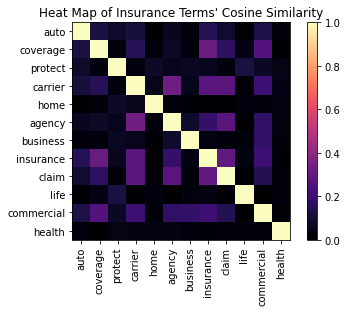

In [0]:
# fill distances matrix
distance_matrix = np.ones((len(relevant_terms_gemini), len(relevant_terms_gemini)))

for i in range(len(relevant_terms_gemini)):
  for j in range(i+1, len(relevant_terms_gemini)):
    distance_matrix[i][j] = terms_similarities[(relevant_terms_gemini[i],relevant_terms_gemini[j])]
    distance_matrix[j][i] = distance_matrix[i][j]

# Plot the heatmap
plt.imshow(distance_matrix, cmap='magma', interpolation='nearest')
plt.colorbar()
plt.xticks(list(range(len(relevant_terms_gemini))), relevant_terms_gemini, rotation=90)
plt.yticks(list(range(len(relevant_terms_gemini))), relevant_terms_gemini)
plt.title(f"Heat Map of {industry_name} Terms' Cosine Similarity")
plt.show()

##### Clustering of Terms into Categories

In [0]:
# Specify the number of clusters (k) root of number of terms
k = int(np.ceil((len(relevant_terms_gemini))**0.5))

# Create a KMeans model
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the model to the distance matrix (treating it as samples)
for i in range(len(distance_matrix)):
  for j in range(len(distance_matrix[0])):
    distance_matrix[i][j] = 1 - distance_matrix[i][j]
kmeans.fit(distance_matrix)

# Get cluster labels for each item
item_labels = kmeans.labels_

# Print cluster assignments for each item
clusters = {i: [] for i in range(k)}
for i, label in enumerate(item_labels):
  clusters[label].append(relevant_terms_gemini[i])

# give names to the clusters
clusters_names = model.generate_content(f"Here are {k} lists of terms which are related to Data Science. Give a two words unique title to each list that describes the terms. Write your answer in the following format: title_of_list_1, title_of_list_2, ..title_of_list_k. don't add numbering and without new lines. The lists: {list(clusters.values())}.").text
clusters_names = clusters_names.split(",")
for old_key, new_key in zip(list(clusters.keys()), clusters_names):
  clusters[new_key] = clusters.pop(old_key, None)

##### Treemap of Terms' Frequencies with Categories

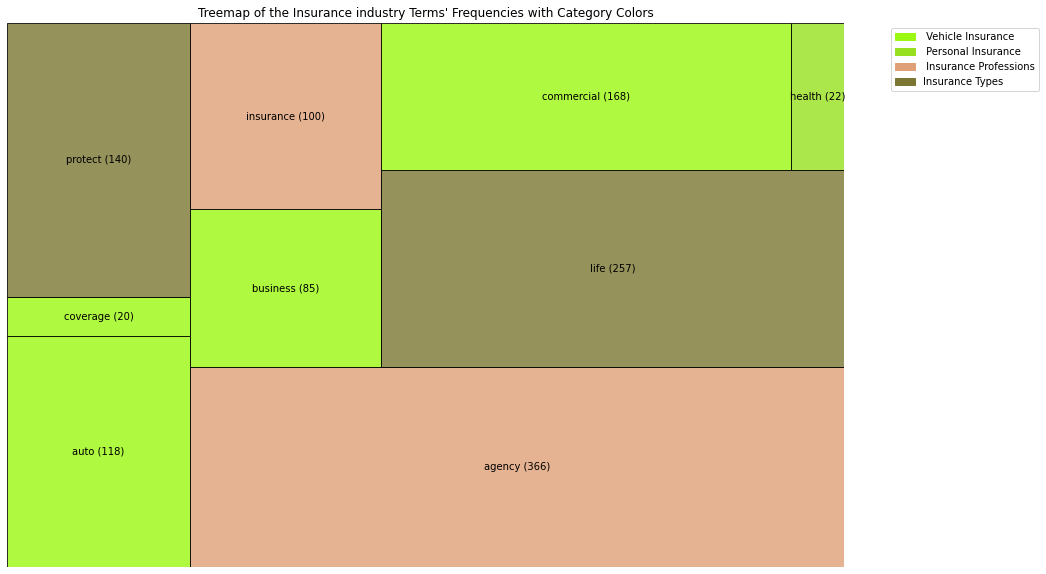

In [0]:
# get term counts
terms = relevant_terms_gemini
terms_temp = [t for t in terms]
term_counts = []
for t in relevant_terms_gemini:
    if t in list(top_about_words_dict.keys()):
        term_counts.append(top_about_words_dict[t])
    else:
        terms_temp.remove(t)
terms = terms_temp


# Create a dictionary to map terms to their categories
terms2categories = {}
for term in relevant_terms_gemini:
    for k, v in clusters.items():
        if term in v:
            terms2categories[term] = k
            break

# Assign random colors to categories
unique_categories = set(terms2categories.values())
category_colors = {cat: f"#{random.randint(0, 0xFFFFFF):06x}" for cat in unique_categories}

# Create the treemap
plt.figure(figsize=(15, 10))
squarify.plot(
    sizes=term_counts,
    label=[f"{term} ({count})" for term, count in zip(terms, term_counts)],
    color=[category_colors[terms2categories[term]] for term in terms],
    alpha=0.8,
    edgecolor="black")
plt.axis("off")
plt.title(f"Treemap of the {industry_name} industry Terms' Frequencies with Category Colors")
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat], label=cat) for cat in unique_categories]
plt.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1.05, 1))  # Adjust the coordinates here

plt.show()


##### Histogram of Companies' Specialitie Frequencies

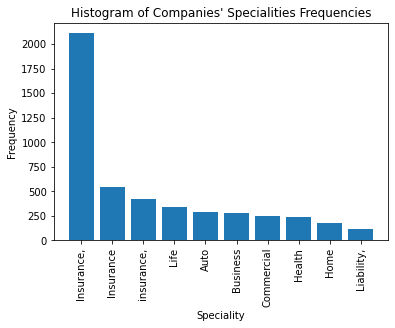

In [0]:
row = final_df.filter(F.col("industries") == industry_name).collect()

# build dict of the specialities and their counts
top_specialties_words_companies = str(row).split("top_specialties_words")[1].split("top_profiles_about_posts_words")[0]
top_specialties_dict = {}
for list_taw in [top_specialties_words_companies]:
  for char in ["[", "]", "=", ")", "'"]:
      list_taw = list_taw.replace(char, "")
  list_taw = list_taw.split(", ")
  for i in range(0, len(list_taw), 2):
    try:
        word = list_taw[i]
        number = int(list_taw[i+1])
        top_specialties_dict[word] = number
    except:
        continue

# Plotting
top_specialties_dict = dict(sorted(top_specialties_dict.items(), key=lambda item: item[1], reverse=True))
plt.bar(top_specialties_dict.keys(), top_specialties_dict.values())
plt.xlabel('Speciality')
plt.ylabel('Frequency')
plt.title("Histogram of Companies' Specialities Frequencies")
plt.xticks(rotation=90)
plt.show()



##### Top 10 Industries by Company Count in the Meta-Industry Bar Chart

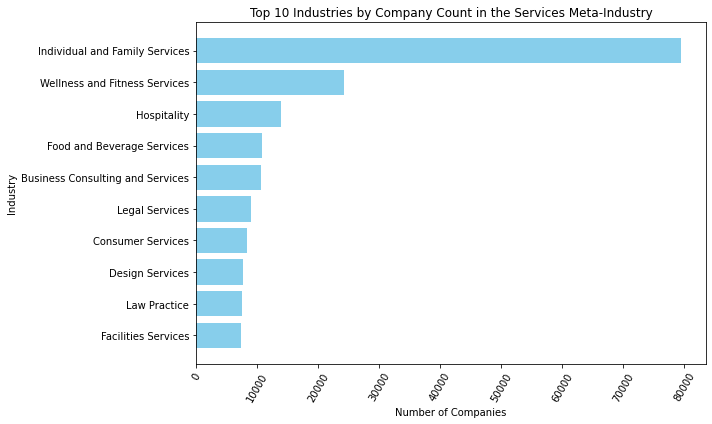

In [0]:
def get_industries_under_meta(industry_name, industry_dict):
    choosen_meta_industry = industry_dict[industry_name]

    industries_under_meta = []
    for industry, meta in industry_dict.items():
        if meta == choosen_meta_industry:
            industries_under_meta.append(industry)
    return industries_under_meta

industries_under_meta = get_industries_under_meta(industry_name, meta_industries_12) 



def count_companies_by_industry(companies_df: DataFrame, industries_under_meta: list):
    selected_df = companies_df.select("industries")
    split_df = selected_df.withColumn("industries_array", split(col("industries"), ","))
    exploded_df = split_df.select(explode("industries_array").alias("industry"))
    filtered_df = exploded_df.filter(exploded_df.industry.isin(industries_under_meta))
    industry_counts = filtered_df.groupBy("industry").agg(count("*").alias("company_count"))
    industry_dict = {row["industry"]: row["company_count"] for row in industry_counts.collect()}
    return industry_dict

result_dict = count_companies_by_industry(companies, industries_under_meta)


def plot_top_industries(result_dict):
    top_industries = sorted(result_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    industries = [item[0] for item in top_industries]
    counts = [item[1] for item in top_industries]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(industries, counts, color='skyblue')
    plt.xlabel('Number of Companies')
    plt.ylabel('Industry')
    plt.title(f"Top 10 Industries by Company Count in the {meta_industries_12[industry_name]} Meta-Industry")
    plt.xticks(rotation=60)  
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

plot_top_industries(result_dict)

